<a href="https://colab.research.google.com/github/satyajeetmaharana/HandDetection_MaskRCNN/blob/master/Mask%20R%20CNN%20Model%20for%20Hand%20Detection_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask R CNN Model for Hand Detection

## Training and Evaluating a Pre-Trained Mask R-CNN Model on a Custom Hands Dataset

#### *SUBMITTED BY : SATYAJEET MAHARANA *

## 1. See some images from out hands dataset

### 1.1 See an image

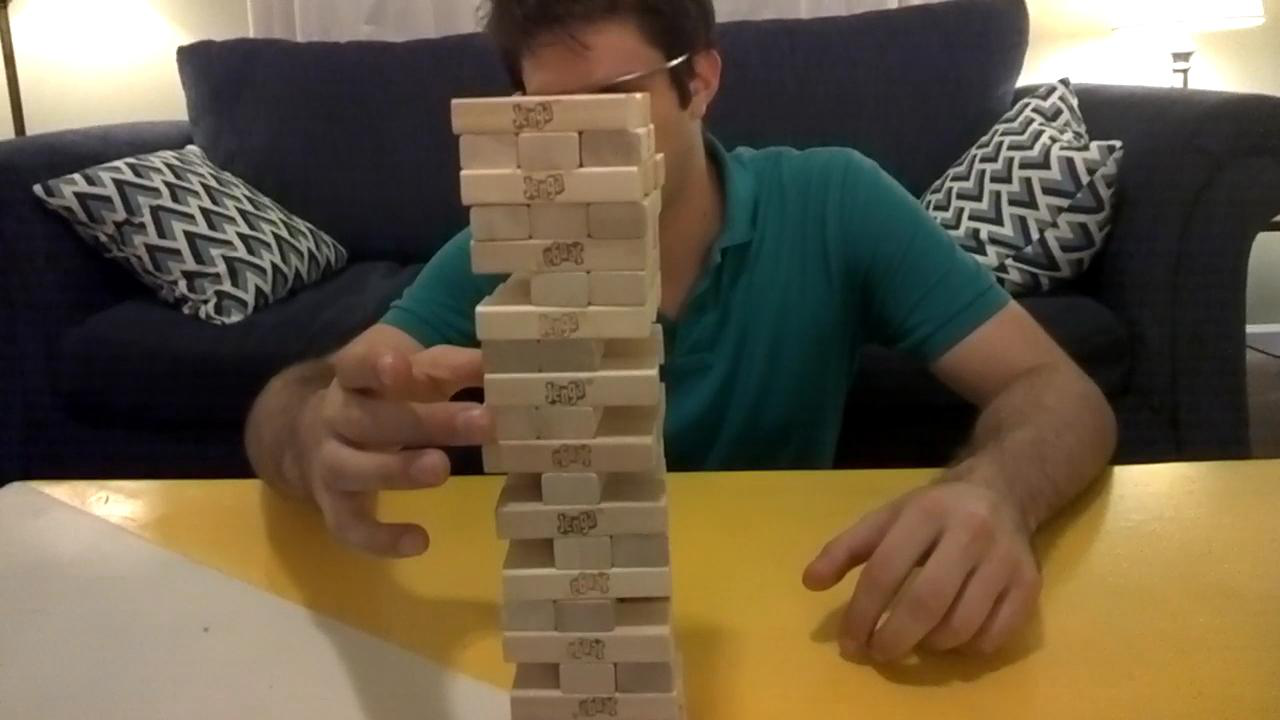

In [0]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from io import StringIO
import csv
img = Image.open('DATA_IMAGES/Image30_1.jpg')
img

### 1.2 See the mask

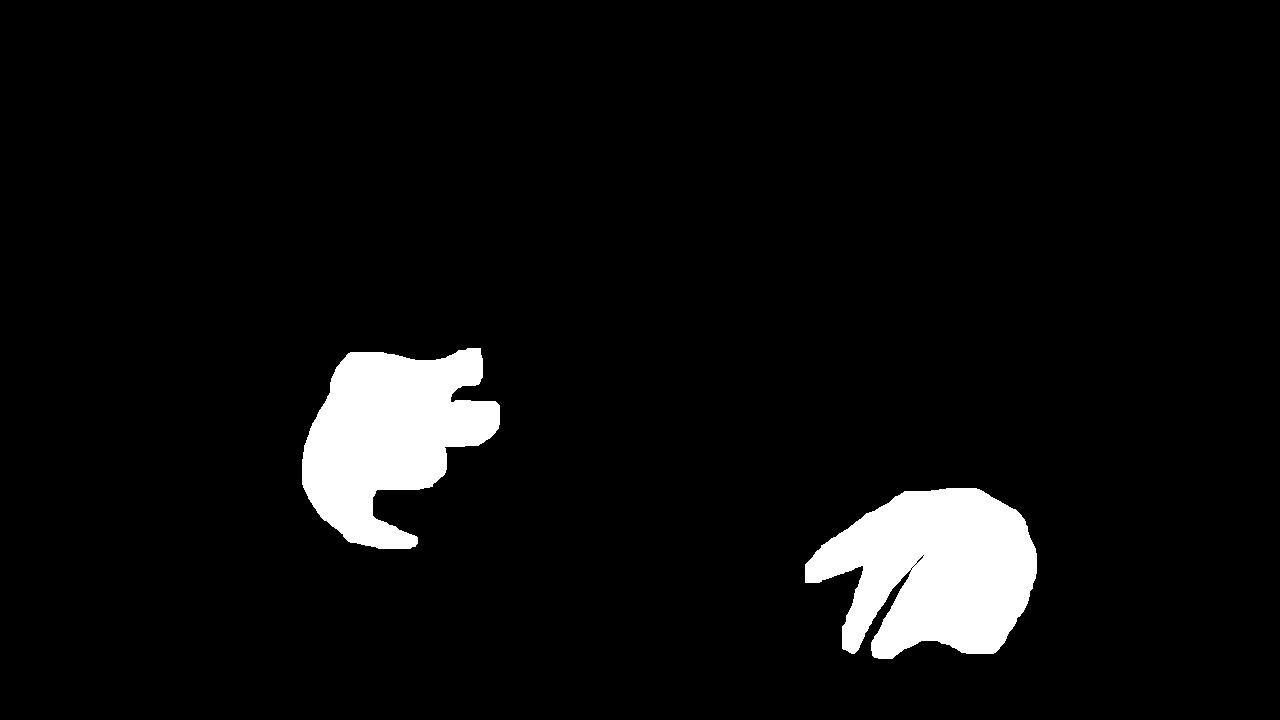

In [0]:
mask = Image.open('DATA_MASKS/Mask30_1.jpg')
mask

## 2.  Cleaning up the data to remove images without masks or boxes

In [0]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from io import StringIO
import csv

t_imgs = []
t_masks = []
t_boxes = []

tempimgs = list(sorted(os.listdir(os.path.join('', "DATA_IMAGES"))))
tempmasks = list(sorted(os.listdir(os.path.join('', "DATA_MASKS"))))
tempboxes = list(sorted(os.listdir(os.path.join('', "DATA_BOXES"))))
index = 0
for img in list(sorted(os.listdir(os.path.join('', "DATA_IMAGES")))):
    img_path = os.path.join('', "DATA_IMAGES", tempimgs[index])
    mask_path = os.path.join('', "DATA_MASKS", tempmasks[index])
    boxes_path = os.path.join('', "DATA_BOXES", tempboxes[index])
    img = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path)
    mask = np.array(mask)
    mask = mask > 200
    masks = np.array(mask,dtype=np.uint8)
    
    boxes = []
    with open(boxes_path) as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for row in reader:
            xmin = int(row[0])
            ymin = int(row[1])
            xmax = xmin + int(row[2]) 
            ymax = ymin + int(row[3])
            if(xmin != ymin and xmax != ymax and xmax-xmin >= 20 and ymax-ymin >=20):  
                boxes.append([xmin, ymin, xmax, ymax])
    if (len(boxes) > 0 and np.sum(mask==1) > 0):
        t_imgs.append(tempimgs[index])
        t_masks.append(tempmasks[index])
        t_boxes.append(tempboxes[index])
    index = index + 1

## 3.  Creating our own custom Data set class

In [0]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from io import StringIO
import csv

class HandsDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = t_imgs
        self.masks = t_masks
        self.boxes = t_boxes
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "DATA_IMAGES", self.imgs[idx])
        mask_path = os.path.join(self.root, "DATA_MASKS", self.masks[idx])
        boxes_path = os.path.join(self.root, "DATA_BOXES", self.boxes[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)
        masks = mask > 200
        masks = np.array(masks,dtype=np.uint8)
        bBoxes = np.zeros(masks.shape, dtype=np.uint8)
        boxes = []
        with open(boxes_path) as csv_file:
            reader = csv.reader(csv_file, delimiter=',')
            for row in reader:
                xmin = int(row[0])
                ymin = int(row[1])
                xmax = xmin + int(row[2]) 
                ymax = ymin + int(row[3])
                if(xmin != ymin and xmax != ymax and xmax-xmin >= 20 and ymax-ymin >=20):  
                    boxes.append([xmin, ymin, xmax, ymax])
        if (len(boxes)==0):
            boxes.append([50,100,300,500])
        for bbox in boxes:
            bBoxes[bbox[1]:bbox[3],bbox[0]:bbox[2]] = 1
        
        bBoxes = np.zeros(masks.shape, dtype=np.uint8)
        mask = Image.open(mask_path)
        mask = np.array(mask)
        masks = np.zeros((len(boxes),mask.shape[0],mask.shape[1]))
        maskTmp = Image.open(mask_path)
        maskTmp = np.array(maskTmp,dtype=np.uint8)
        boxIndex = 0
        for bbox in boxes:
            bBoxes = np.zeros(maskTmp.shape, dtype=np.uint8)
            bBoxes[bbox[1]:bbox[3],bbox[0]:bbox[2]] = 1
            mask1 = np.multiply(maskTmp,bBoxes)
            mask1 = mask1 > 200
            mask1 = np.array(mask1,dtype=np.uint8)
            masks[boxIndex,:,:] = mask1
            boxIndex = boxIndex + 1
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        num_objs = len(boxes)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks,dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [0]:
dataset = HandsDataset('')
dataset[0]

(<PIL.Image.Image image mode=RGB size=1280x720 at 0x2B2FD3D1FA90>,
 {'boxes': tensor([[139., 602., 280., 720.],
          [600., 571., 930., 714.],
          [470., 197., 607., 296.],
          [313., 193., 437., 285.]]),
  'labels': tensor([1, 1, 1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
         

## 4.  Defining the model

### 4.1 Finetuning from a pretrained model

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

### 4.2 Create an Instance segmentation model for the Hands Dataset

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

### 4.3 Training and evaluation functions

In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### 4.4 Creating Dataloaders for the Hands Dataset

In [0]:
dataset = HandsDataset('', get_transform(train=True))
dataset_test = HandsDataset('', get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

## USE THE BELOW TWO LINES IF YOU JUST WANT TO TEST OUT IN A QUICKER TIME

#dataset = torch.utils.data.Subset(dataset, indices[:50])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[50:62])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn,pin_memory=True)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn, pin_memory=True)

### 4.5 Instantiate the model and the optimizer

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2

model = get_instance_segmentation_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

## 5. Training the model (20 epochs)

In [0]:
from engine import train_one_epoch, evaluate
num_epochs = 20

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)
    torch.save(model.state_dict(), '/scratch/sm8235/final20_checkpoint' + str(epoch) + '.pth')

Epoch: [0]  [   0/1184]  eta: 0:38:42  lr: 0.000010  loss: 4.0644 (4.0644)  loss_classifier: 0.5459 (0.5459)  loss_box_reg: 0.1851 (0.1851)  loss_mask: 3.2069 (3.2069)  loss_objectness: 0.0971 (0.0971)  loss_rpn_box_reg: 0.0295 (0.0295)  time: 1.9616  data: 1.0107  max mem: 14896
Epoch: [0]  [  10/1184]  eta: 0:13:16  lr: 0.000060  loss: 3.6166 (3.3936)  loss_classifier: 0.5310 (0.5207)  loss_box_reg: 0.1851 (0.1849)  loss_mask: 2.7773 (2.5783)  loss_objectness: 0.0799 (0.0856)  loss_rpn_box_reg: 0.0225 (0.0240)  time: 0.6787  data: 0.0921  max mem: 14896
Epoch: [0]  [  20/1184]  eta: 0:11:14  lr: 0.000110  loss: 2.5154 (2.6023)  loss_classifier: 0.4530 (0.4519)  loss_box_reg: 0.1796 (0.1785)  loss_mask: 1.4601 (1.8534)  loss_objectness: 0.0799 (0.0939)  loss_rpn_box_reg: 0.0224 (0.0246)  time: 0.5100  data: 0.0002  max mem: 14896
Epoch: [0]  [  30/1184]  eta: 0:10:36  lr: 0.000160  loss: 1.1849 (2.1007)  loss_classifier: 0.3201 (0.4039)  loss_box_reg: 0.1952 (0.1903)  loss_mask: 0.599

## 6. Save the trained model for future use

In [0]:
torch.save(model.state_dict(), '/scratch/sm8235/final20_complete_epoch.pth')

## 7. Load the trained model for evaluation on some data

In [0]:
model = get_instance_segmentation_model(num_classes)
model.to(device)
model.load_state_dict(torch.load('/scratch/sm8235/py_complete_epoch.pth'))
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
         

## 8. Visualize 1 image and mask

### 8.1 Load 1 image and predict the masks

In [0]:
img, _ = dataset_test[10]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [0]:
prediction

[{'boxes': tensor([[251.4757, 602.6739, 487.1089, 719.5874],
          [643.7448, 564.1813, 913.3137, 719.3730],
          [484.9822, 325.7340, 636.2838, 451.0611],
          [636.4812, 303.0608, 799.9165, 410.4289]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9999, 0.9999, 0.9998, 0.9997], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
           

### 8.2 Actual Image

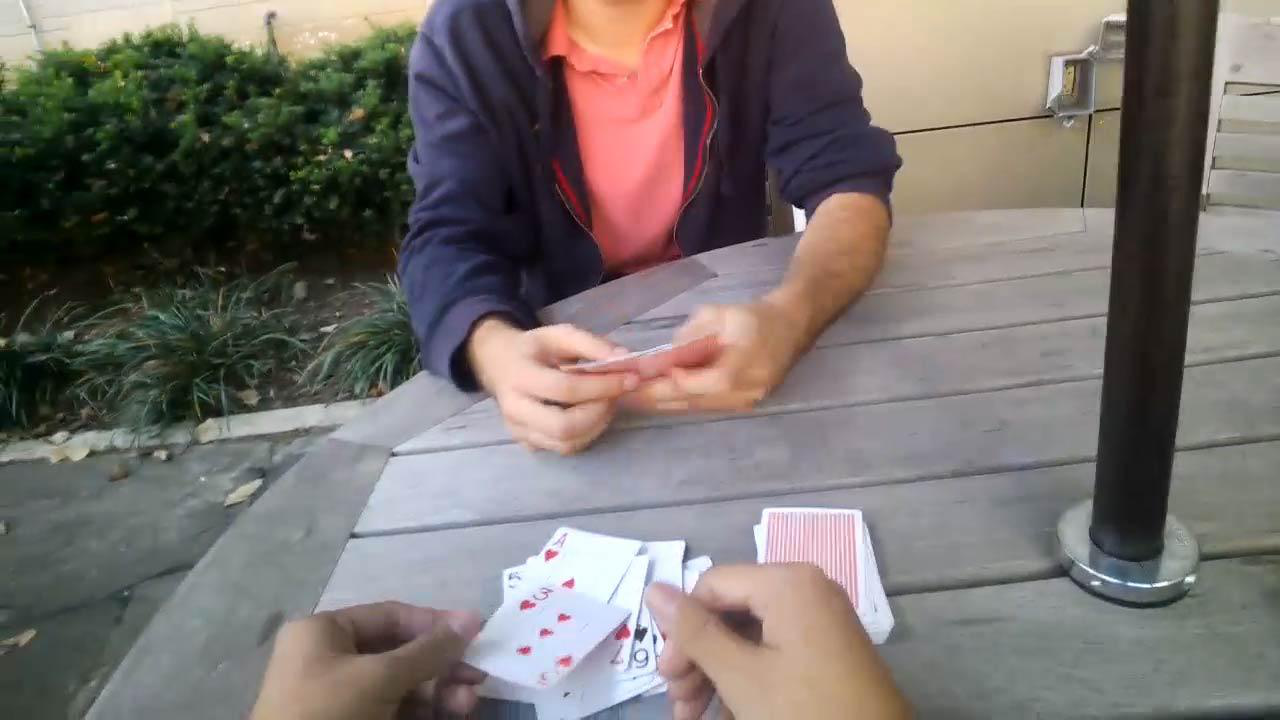

In [0]:
backImage = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
backImage

### 8.3 Masks on Hands overlayed on the actual image

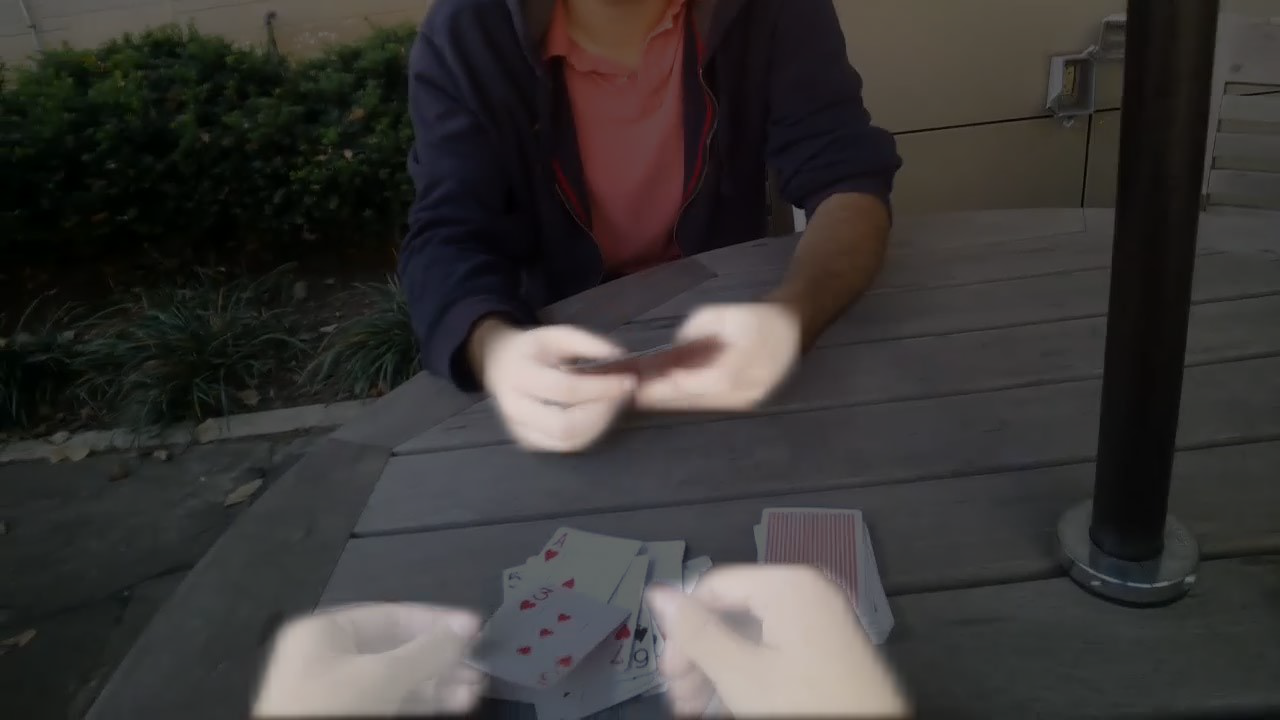

In [0]:
mask1Img = Image.fromarray(prediction[0]['masks'][1, 0].mul(150).byte().cpu().numpy()).convert("RGB")
mask2Img = Image.fromarray(prediction[0]['masks'][0, 0].mul(150).byte().cpu().numpy()).convert("RGB")
combinedImage = np.zeros_like(prediction[0]['masks'][1, 0].mul(200).byte().cpu().numpy())
combinedImage = torch.sum(prediction[0]['masks'][:, 0],dim=0)
alphaBlended1 = Image.blend(Image.fromarray(combinedImage.mul(200).cpu().numpy()).convert("RGB"), backImage, alpha=.4)
alphaBlended1